[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sascha-senko/TensorflowCourse/blob/main/ANNwTFHW7.ipynb)

## Global TODO

* TODO: Set the settings right again
* Make sure that L2 regularization loss is accounted for this time!
* Look at notebook from flipped classroom
* Define Resnet block
* Maybe use the previous week's sample solution
* General training pipeline

## Imports

In [305]:
import matplotlib.pyplot as plt
import numpy as np
# TODO: uncomment later
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, \
    BatchNormalization, ELU, Flatten, Dense, ZeroPadding2D, AveragePooling2D, \
    Layer, GlobalAveragePooling2D, concatenate
from tensorflow.keras.regularizers import L2
from functools import partial  

## Define Bottleneck layer

In [306]:
def bottleneck(filter_dim):
    return Conv2D(filter_dim, kernel_size=1)

## Define Resnet Block

In [307]:
class ResidualBlock(Layer):
    # TODO: some documentation regarding initializer argument and stuff.
    def __init__(self, input_dim, layer_list, custom_weight_init=None):
        super(ResidualBlock, self).__init__()

        # TODO
        """
        output_dim = input_dim

        for layer in layer_list:
            # we tell each layer the input shape so that we can check
            # if first input and final output dimension coincide.
            # TODO: output_dim somehow is a whole tensor, not just shape
            # TODO: remove
            #print(output_dim)
            print("hello!")
            output_dim = layer.compute_output_shape(output_dim)

        # assert that first input and last output have same dimension
        if not output_dim == input_dim:
            raise ValueError("ResidualBlock: first and final dimension are different")
        """

        self.layer_list = layer_list
        self.custom_weight_init = custom_weight_init

        if custom_weight_init:
            self.custom_weight = tf.Variable(custom_weight_init())        

    # TODO: Is there any way to use @tf.function on call even when we have to differentiate between training and testing mode (e.g. for batch norm and dropout)? Since to my understanding, if we use call for training even once, it can't go back to testing mode anymore (since tf.function evaluates the python boolean only on the first call to my understanding). I tried using tf.constant(True) instead, but it seemed to yield the same problem in my case (if my memory serves me right - that was last week)
    # TODO: try with tf.constant(True, shape=(1)) once.
    def call(self, x, training):
        y = x
        
        for layer in self.layer_list:
            if isinstance(layer, Dropout) or isinstance(layer, BatchNormalization):
                y = layer(y, training=training)
            else:
                y = layer(y)                       
        
        # add initial input
        if self.custom_weight_init:
            y = y + self.custom_weight * x
        else:
            y = y + x

        return y

# TODO: add a tf.ones(input_dim) weight to multiple with x. I could also do the same with DenseNet
# TODO: Optionally, create more specific Resnet block that repeats certain structure
#ResidualBlock((4, 28, 28, 3), [Conv2D(10, 1), Conv2D(3, 1)])

class SpecificResBlock(ResidualBlock):
    def __init__(self, input_dim, custom_weight_init=None):
        layer_list = [
            BatchNormalization(), ELU(), Conv2D(64, 1),
            # use Zero Padding to get same dimension as at start
            BatchNormalization(), ELU(), Conv2D(128, 3), ZeroPadding2D(),
            BatchNormalization(), ELU(), Conv2D(3, 3), ZeroPadding2D()
        ]

        super(SpecificResBlock, self).__init__(input_dim, layer_list, custom_weight_init=None)

## Define ResNet Model

In [308]:
class ResNet(Model):
    def __init__(self, num_blocks, input_dim):
        super(ResNet, self).__init__()
        # start with conv net, as recommended by homework
        layer_list = []
        # TODO: proper weights again
        layer_list.extend([Conv2D(64, kernel_size=3), ZeroPadding2D()])

        # TODO
        for layer in layer_list:
            input_dum = layer.compute_output_shape(input_dim)

        for i in range(num_blocks):
            res_block = SpecificResBlock(input_dim)
            layer_list.append(SpecificResBlock)

        layer_list.extend([GlobalAveragePooling2D(), Dense(10, activation=tf.keras.activations.softmax)])

        # TODO: Somehow, around here, the class information gets lost
        for layer in layer_list:
            print(layer.__class__)

        self.layer_list = layer_list

    def call(self, x, training):
        for layer in self.layer_list:
            # TODO: remove
            print(layer.__class__)
            print(isinstance(layer, (Dropout, BatchNormalization, ResidualBlock, SpecificResBlock)))
            if isinstance(layer, (Dropout, BatchNormalization, ResidualBlock)):
                x = layer(x, training=training)
            else:
                x = layer(x)              
        return x    

## Define Densenet Block


In [309]:
class DenseBlock(Layer):
# TODO: Seeing Table 2 in https://arxiv.org/pdf/1608.06993.pdf, I recommend k = 12
# TODO: correct __init__ arguments
# TODO: think if I really want to use the custom_weight_init or not
    def __init__(self, num_layers, growth_fac):
        super(DenseBlock, self).__init__()

        layer_list = []

        for i in range(num_layers):
            layer_list.extend(
                [BatchNormalization(),
                 ELU(), Conv2D(growth_fac, 3, padding='same')]
            )

        self.layer_list = layer_list

    def call(self, x, training):
        for layer in self.layer_list:
            if isinstance(layer, (BatchNormalization, Dropout)):
                x = concatenate([layer(x, training=training), x])
            else:
                x = concatenate([layer(x), x])

        return x

## Define Transition layer

In [310]:
class TransitionLayer(Layer):
    def __init__(self, num_filters):
        super(TransitionLayer, self).__init__()
        self.layer_list = [
            BatchNormalization(),
            bottleneck(num_filters),
            AveragePooling2D()
        ]

    def call(self, x):

        for layer in self.layer_list:
            x = layer(x)

        return x

## Define DenseNet model

In [311]:
class DenseNet(Layer):
    def __init__(self, input_dim, num_dense_blocks, num_layers, growth_fac):
        super(DenseNet, self).__init__()
        # TODO: make bigger again
        self.layer_list = [
            ZeroPadding2D(), Conv2D(64, kernel_size=3)
        ]

        for layer in self.layer_list:
            input_dim = layer.compute_output_shape(input_dim)

        for i in range(num_dense_blocks-1):
            dense = DenseBlock(num_layers, growth_fac)
            self.layer_list.append(dense)
            # TODO: I can still play around with that
            bottleneck_dim = dense.compute_output_shape(input_dim)[0] // num_layers
            transit = TransitionLayer(bottleneck_dim)
            self.layer_list.append(transit)
            input_dim = transit.compute_output_shape(input_dim)

        self.layer_list.append(DenseBlock(num_layers, growth_fac))

        self.layer_list.extend([GlobalAveragePooling2D(), Dense(10, activation=tf.keras.activations.softmax)])
# on as the number of channels parameters to your Transition Layer

        # TODO: call
    def call(self, x, training):
        for layer in self.layer_list:
            if isinstance(layer, (BatchNormalization, Dropout, DenseBlock)):
                x = layer(x, training)
            else:
                x = layer(x)

        return x
# Original paper used L = 40 (also summe num_layers = 40

## Model from previous week

In [312]:
# TODO: rename architecture to layer_list
class ConvNet(Model):

    def __init__(self):
        super(ConvNet, self).__init__()
        # store architecture as a list to avoid naming individual layers
        architecture = []

        def conv_sub_arch(filters, kernel_size=[3,3]):
            """ Convenience function for returning getting used sub architectures """
            architecture.extend([ZeroPadding2D(), \
                                 Conv2D(filters=filters, kernel_size=kernel_size, kernel_regularizer=L2()), \
                                 BatchNormalization(), ELU()])

        def pool_sub_arch():
            """ Another convenience function for getting often used sub architectures """
            architecture.extend([MaxPooling2D(), Dropout(0.1)])
        
        conv_sub_arch(64)
        # TODO: uncomment later on
        """
        for i in range(3):
            conv_sub_arch(128)
        pool_sub_arch()   
        for i in range(3):
            conv_sub_arch(128)
        pool_sub_arch()   
        conv_sub_arch(256)
        conv_sub_arch(256)
        pool_sub_arch()
        conv_sub_arch(512)
        conv_sub_arch(1024)
        pool_sub_arch()
        conv_sub_arch(128)
        conv_sub_arch(128, kernel_size=[1,1])
        conv_sub_arch(128, kernel_size=[1,1])
        pool_sub_arch()
        conv_sub_arch(128)
        pool_sub_arch()
        """
        architecture.append(Flatten())
        architecture.append(Dense(10, activation=tf.keras.activations.softmax))

        self.architecture = architecture

     
    # no tf.function as that prevents us from switching between training
    # and evaluation mode in call method
    def call(self, x, training):
        for layer in self.architecture:
            if isinstance(layer, Dropout) or isinstance(layer, BatchNormalization):
                x = layer(x, training=training)
            else:
                x = layer(x)                   
        return x        

## Load dataset

In [313]:
# TODO: remove percent
train_data, test_data = tfds.load(
    'cifar10', split=['train[:1%]', 'test[:1%]'], as_supervised=True)

## Inspect data set

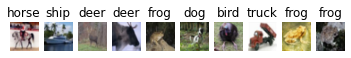

In [314]:
fig, ax = plt.subplots(1,10)
shapes = []

num_to_name = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
"ship", "truck"]

for i, (img, lbl) in enumerate(train_data):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(num_to_name[lbl.numpy()])
    ax[i].axis("off")
    shapes.append(img.shape)

## Define some constants

In [315]:
# arbitrarily set. Feel free to change these
SHUFFLE_SIZE = int(train_data.cardinality())
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

## Prepare data

In [316]:
def process_inp_and_label(input, label, training):
    """ rescale inputs and onehotify labels """
    new_input = input / 255
    return new_input, tf.one_hot(label, 10)

def data_pipeline(data, training):
    """ helper function for data pipeline - does all the things we need """
    map_func = partial(process_inp_and_label, training=training)
    data = data.map(map_func)
    # arbitrarily set buffer_size - feel free to use sth. else
    data = data.shuffle(buffer_size=SHUFFLE_SIZE)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

train_data = data_pipeline(train_data, True)
test_data = data_pipeline(test_data, False)

## Define helper functions

In [317]:
def train_step(model, input, target, loss_function, optimizer):
    accuracy = None

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        # boolean argument for training mode
        prediction = model(input, True)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = np.mean(accuracy)

    return loss, accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        # boolean argument for evaluation mode
        prediction = model(input, False)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.extend(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

## Prepare for training

In [318]:
num_epochs = 2
learning_rate = 0.001
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# TODO: check that indeed, when I enter for loop,
#  we loop through the whole thing.
#  Use cardinality and epoch counter to check
INPUT_DIM = next(iter(train_data))[0].shape
# TODO: weight shit
NUM_RES_BLOCKS = 2

NUM_DENSE_BLOCKS = 2
NUM_LAYERS = 3
GROWTH_FAC = 1

models = ['ConvNet()',
          'ResNet({}, {})'.format(NUM_RES_BLOCKS, INPUT_DIM),
          'DenseNet({}, {}, {}, {})'.format(
              INPUT_DIM, NUM_DENSE_BLOCKS, NUM_LAYERS, GROWTH_FAC
          )]

## Train

In [319]:
for model_str in models:

    # remove all active models for memory purposes
    tf.keras.backend.clear_session()
    model = eval(model_str)


    # Initialize lists for later visualization.
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # TODO: check if this is truly correct or not
    TRAIN_STAT_DIM = (int(train_data.cardinality()))

    for epoch in range(num_epochs):
        print('Epoch: ' + str(epoch+1))

        # shuffle train data. No need to shuffle test data
        train_data = train_data.shuffle(buffer_size=BATCH_SIZE)

        train_loss_stat = np.empty(TRAIN_STAT_DIM)
        train_accuracy_stat = np.empty(TRAIN_STAT_DIM)
        for i, (input, target) in enumerate(train_data):
            train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
            train_loss_stat[i] = train_loss
            train_accuracy_stat[i] = train_accuracy
        train_losses.append(np.mean(train_loss_stat))
        train_accuracies.append(np.mean(train_accuracy_stat))

        # testing
        test_loss, test_accuracy = test(model, test_data, loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # TODO: save

Epoch: 1
Epoch: 2
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
<class 'tensorflow.python.keras.layers.convolutional.ZeroPadding2D'>
<class 'type'>
<class 'type'>
<class 'tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D'>
<class 'tensorflow.python.keras.layers.core.Dense'>
Epoch: 1
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
False
<class 'tensorflow.python.keras.layers.convolutional.ZeroPadding2D'>
False
<class 'type'>
False
<class 'type'>
False
<class 'tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D'>
False


AttributeError: ignored

## Plot

In [ ]:
plot_stats(train_losses, test_losses, "Loss")
plot_stats(train_accuracies, test_accuracies, "Accuracy")

## Assert test accuracy over 85%

In [ ]:
assert test_accuracies[-1] >= 0.85
print(test_accuracies)

## Debug

In [ ]:
res = SpecificResBlock((128, 32, 32, 3))
print(res.__class__)
res(next(iter(train_data))[0]).__class__